Source: https://www.kaggle.com/ahassaine/pure-image-processing-lb-0-274/code 


# Libraries and Global Parameters 

In [69]:
import os
#import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte
from skimage.transform import resize
#import skimage
#import glob
import random
from random import randint #, shuffle

from skimage.morphology import label


from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, Dense, \
    UpSampling2D, BatchNormalization, add, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.losses import binary_crossentropy

model_checkpoint_file='bw_model_v4.h5'

# Root folders for test and training data
train_root = "./stage1_train"
test_root = "./stage1_test"

# Size we resize all images to
#image_size = (128,128)

img_height = 128
img_width = 128

# Preparing the Data

In [35]:
## Import Training Data Images 
train_dirs = os.listdir(train_root)
train_filenames=[os.path.join(train_root,file_id) + "/images/"+file_id+".png" for file_id in train_dirs]
# Convert to B&W inline
#train_images=[cv2.cvtColor(cv2.imread(imagefile),cv2.COLOR_BGR2GRAY) for imagefile in train_filenames]
train_images=[imread(imagefile,as_grey=True) for imagefile in train_filenames]

## Import Test Data Images 
test_dirs = os.listdir(train_root)
train_filenames=[os.path.join(train_root,file_id) + "/images/"+file_id+".png" for file_id in test_dirs]
# Convert to B&W inline
#train_images=[cv2.cvtColor(cv2.imread(imagefile),cv2.COLOR_BGR2GRAY) for imagefile in train_filenames]
test_images=[imread(imagefile,as_grey=True) for imagefile in test_filenames]

# Use this instead if you want color images
#train_images=[imread(imagefile) for imagefile in train_filenames]


In [36]:
## Import Training Masks
# this takes longer than the training images because we have to
# combine a lot of mask files

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, imread(os.path.join(train_root,mask_file)))
        else:
            # read first mask in
            mask = imread(os.path.join(train_root,mask_file))
    
    return img_as_ubyte(mask)

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]

#def collapse_masks(mask_list):
#    for i, mask_file in enumerate(mask_list):
#        print(i)
#        print(mask_file)
        
#testing = [collapse_masks(mask_files) for mask_files in train_mask_files]

# Divide output of each mask by 255 to make a 1/0 binary mask
train_masks = [ collapse_masks(mask_files) for mask_files in train_mask_files ]


In [37]:
train_masks[0].max()

255

Image #: 17. Image Sizes: (360, 360) (360, 360)


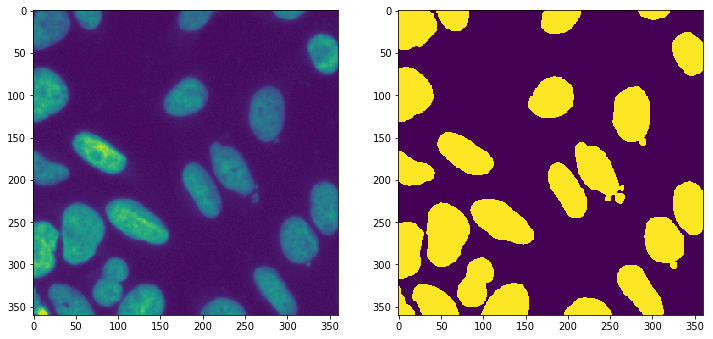

Image #: 502. Image Sizes: (256, 256) (256, 256)


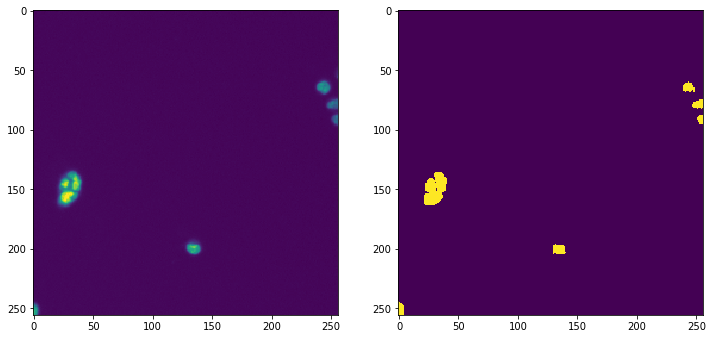

Image #: 163. Image Sizes: (256, 256) (256, 256)


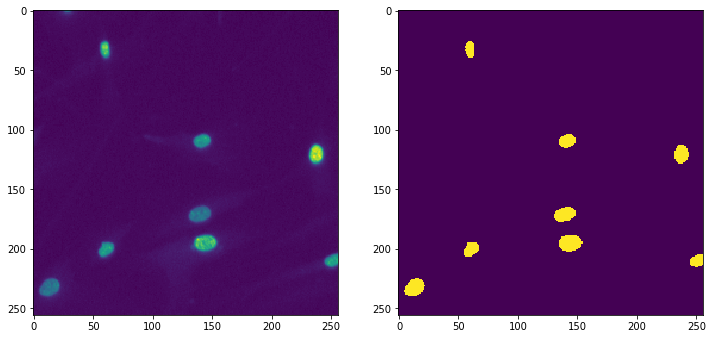

In [40]:
# Plot a training test and mask image side by side
def plot_side_by_side(image_ds,mask_ds,image_num):
    print('Image #: ' + str(image_num) + '. Image Sizes: ' + str(image_ds[image_num].shape) + ' ' + str(mask_ds[image_num].shape))
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image_ds[image_num])
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(mask_ds[image_num])
    plt.show()
    
# Plots random corresponding images and masks
def plot_check(images,masks,rand_imgs=None,img_nums=None):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(images,masks,randint(0,len(images)-1))
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(images,masks,img_nums[i])
    
#plot_side_by_side(train_images,train_mask_images,38)
# Plot a few random images 
plot_check(train_images,train_masks,rand_imgs=3)
#plot_check(train_images,train_mask_images,img_nums=[309])



In [ ]:
plot_check(train_images,train_mask_images,img_nums=[309])


In [41]:
# Resize everything
# Also do dtype conversions

# Scaling
resized_train_images = [ img_as_uint(resize(image,(img_width,img_height),mode='reflect')) for image in train_images] 
resized_train_masks = [ resize(image,(img_width,img_height),mode='reflect').astype(bool) for image in train_masks] 

#Croping

#crop_size=64

#resized_train_images = [ image[int(0.5*(image.shape[0]-crop_size)):int(0.5*(image.shape[0]+crop_size)),
#   int(0.5*(image.shape[1]-crop_size)):int(0.5*(image.shape[1]+crop_size))] for image in train_images] 

#resized_train_mask_images = [ image[int(0.5*(image.shape[0]-crop_size)):int(0.5*(image.shape[0]+crop_size)),
#   int(0.5*(image.shape[1]-crop_size)):int(0.5*(image.shape[1]+crop_size))] for image in train_mask_images] 


C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to 

In [42]:
# check max pixel values
print(resized_train_images[309].max())
print(resized_train_images[16].max())

22231
43562


Original image and mask
Image #: 309. Image Sizes: (512, 640) (512, 640)


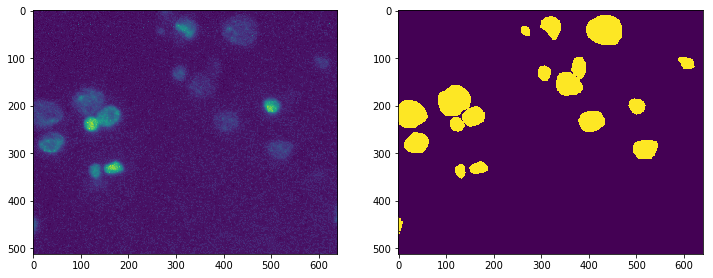

Resized image and mask
Image #: 309. Image Sizes: (128, 128) (128, 128)


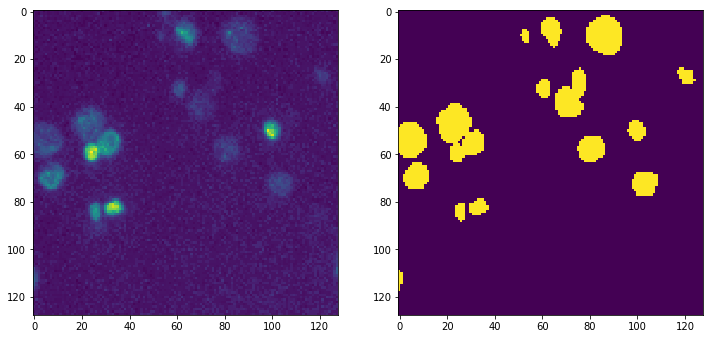

In [44]:
# Check to see that my resizing and compression is screwing stuff up
rand_img_num = randint(0,len(train_images))
#plot_check(compressed_train_images,compressed_train_masks,img_nums=[rand_img_num])
#plot_check(train_images,train_mask_images,img_nums=[rand_img_num])

print('Original image and mask')
plot_check(train_images,train_masks,img_nums=[309])
print('Resized image and mask')
plot_check(resized_train_images,resized_train_masks,img_nums=[309])

#plot_check(train_images,train_mask_images,img_nums=[664])
#print(train_images[664].max())

In [45]:
# Reshape model inputs
train_X = np.reshape(np.array(resized_train_images),(len(resized_train_images),img_height,img_width,1))
train_Y = (np.reshape(np.array(resized_train_masks),(len(resized_train_masks),img_height,img_width,1)))

# Check size of arrays we are inputting to model
# This is important! We need the datasets to be as 
# small as possible to reduce computation time
print(train_X.shape)
print(train_Y.shape)
print(train_X.nbytes)
print(train_Y.nbytes)
print(train_X.dtype)
print(train_Y.dtype)

(670, 128, 128, 1)
(670, 128, 128, 1)
21954560
10977280
uint16
bool


In [37]:
train_Y[0].dtype
#train_X[0]

dtype('bool')

Image #: 5. Image Sizes: (128, 128) (128, 128)


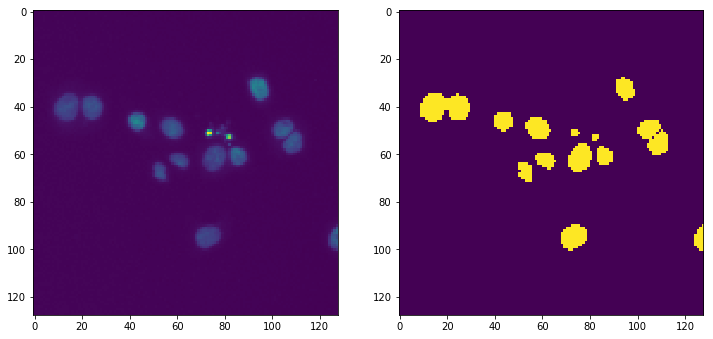

Image #: 119. Image Sizes: (128, 128) (128, 128)


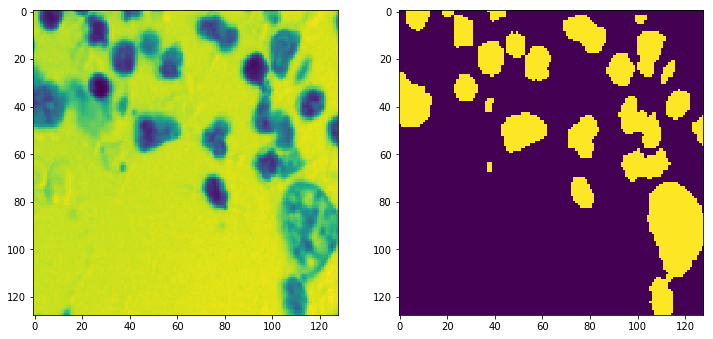

Image #: 356. Image Sizes: (128, 128) (128, 128)


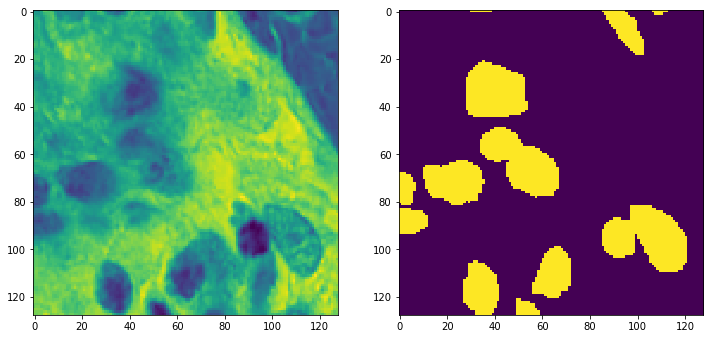

Image #: 602. Image Sizes: (128, 128) (128, 128)


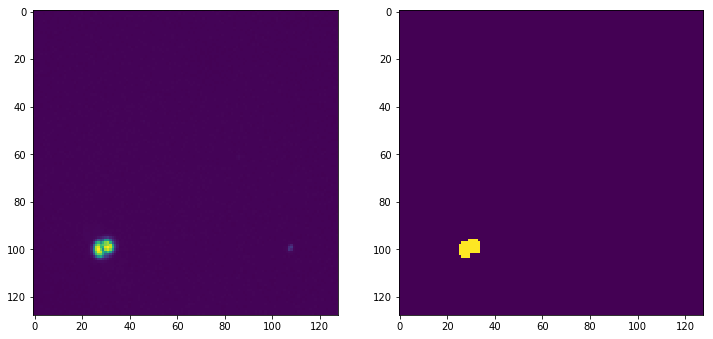

Image #: 5. Image Sizes: (256, 256) (256, 256)


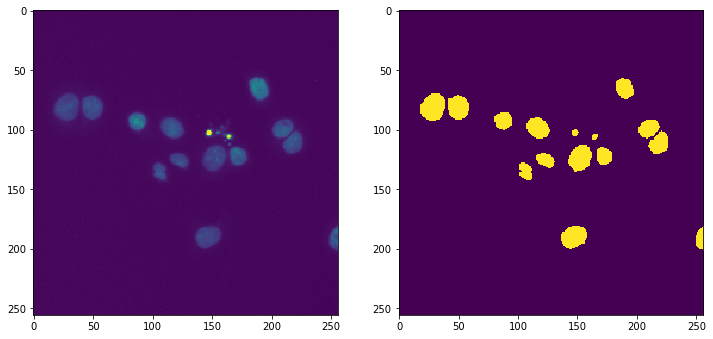

Image #: 119. Image Sizes: (256, 320) (256, 320)


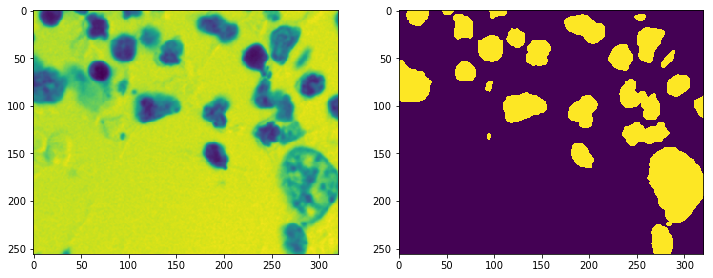

Image #: 356. Image Sizes: (256, 320) (256, 320)


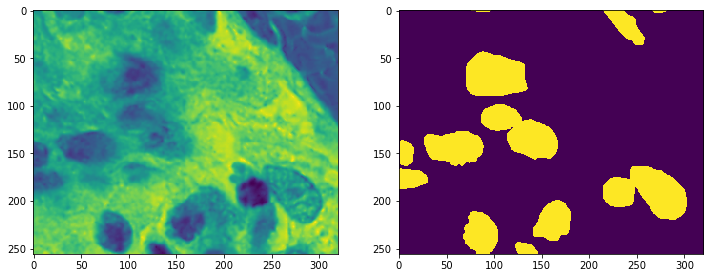

Image #: 602. Image Sizes: (256, 256) (256, 256)


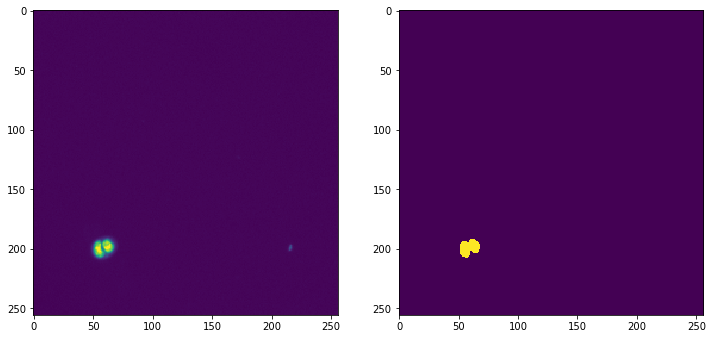

In [38]:
plot_check(np.squeeze(train_X,axis=3),np.squeeze(train_Y,axis=3),img_nums=[5,119,356,602])
plot_check(train_images,train_mask_images,img_nums=[5,119,356,602])

In [209]:
train_X[602].max() # check max pixel value

16

# Now Let's Build the Model

In [10]:
# Loss and metric functions for the neural net
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def create_block(x, filters=32, filter_size=(3, 3), activation='relu',dil_rate=(1,1),dropout_rate=0.1):
#    for i in range(n_block):
    x = Conv2D(filters, filter_size, padding='same', dilation_rate = dil_rate) (x)
    x = Activation('relu') (x)
    x = BatchNormalization() (x) 
    x = Dropout(dropout_rate) (x)
    return x


## master function for creating a net
def get_net(
        input_shape=(img_height, img_width,1),
        lr=0.001,
        loss=bce_dice_loss,
        n_class=1
):
    inputs = Input(input_shape)
    
    # Create layers
    net_body = create_block(inputs)
    net_body = create_block(net_body)
    net_body = create_block(net_body)  # this is an extra layer (compared to MeshNet paper) .. 
    net_body = create_block(net_body,dil_rate=(2,2))
    net_body = create_block(net_body,dil_rate=(4,4))
    net_body = create_block(net_body,dil_rate=(8,8))
    net_body = create_block(net_body,dil_rate=(16,16))
    net_body = create_block(net_body)
    net_body = create_block(net_body)
    # Sigmoid used since we are classifying pixels 1/0. Softmax used for multiclass
    classify = Conv2D(n_class,(1,1),activation='sigmoid') (net_body)
    
    #classify = Activation(activation='sigmoid') (net_body)
    #classify = Dense(1,activation='sigmoid') (net_body)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[dice_coef, binary_crossentropy])

    return model

In [40]:
my_model = get_net()

In [41]:
print(my_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 32)      0         
__________

In [42]:
# Fit model

# Implement learning rate decay https://keras.io/callbacks/#learningratescheduler 

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.65,
                           patience=2,
                           verbose=1,
                        #   min_lr=0.00001,
                           mode='auto') 
# verbose=2 => one line per epoch, 1 = progress bar

### Add an epsilon 
results = my_model.fit(train_X, train_Y, validation_split=0.1, batch_size=15, epochs=50, verbose=1 , shuffle=True,
                    callbacks=[earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/50
600/603 [============================>.] - ETA: 2s - loss: 1.1987 - dice_coef: 0.4968 - binary_crossentropy: 0.5863 
Epoch 00001: val_loss improved from inf to 0.87490, saving model to bw_model_v4.h5
603/603 [==============================] - 626s 1s/step - loss: 1.1962 - dice_coef: 0.4982 - binary_crossentropy: 0.5851 - val_loss: 0.8749 - val_dice_coef: 0.6588 - val_binary_crossentropy: 0.4262
Epoch 2/50
600/603 [============================>.] - ETA: 3s - loss: 0.7616 - dice_coef: 0.7470 - binary_crossentropy: 0.3365 
Epoch 00002: val_loss improved from 0.87490 to 0.71424, saving model to bw_model_v4.h5
603/603 [==============================] - 626s 1s/step - loss: 0.7605 - dice_coef: 0.7474 - binary_crossentropy: 0.3362 - val_loss: 0.7142 - val_dice_coef: 0.7480 - val_binary_crossentropy: 0.3656
Epoch 3/50
600/603 [============================>.] - ETA: 3s - loss: 0.5310 - dice_coef: 0.8310 - binary_crossentropy: 0.2249 
Epoch

In [27]:
# Last run:
# Epoch 00035: val_loss did not improve
# 603/603 [==============================] - 97s 162ms/step - loss: 0.2842 - dice_coef: 0.8622 - binary_crossentropy: 0.1134 - val_loss: 0.3813 - val_dice_coef: 0.8221 - val_binary_crossentropy: 0.1826
# Epoch 00035: early stopping


# Make predictions
final_model = load_model(model_checkpoint_file, custom_objects={'dice_coef': dice_coef, 'bce_dice_loss':bce_dice_loss})
#preds_train = final_model.predict(train_X[:int(train_X.shape[0]*0.9)], verbose=1)
#preds_val = final_model.predict(train_X[int(train_X.shape[0]*0.9):], verbose=1)

preds_train = final_model.predict(train_X, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)

NameError: name 'train_X' is not defined

Original Image and Mask
Image #: 194. Image Sizes: (360, 360) (360, 360)


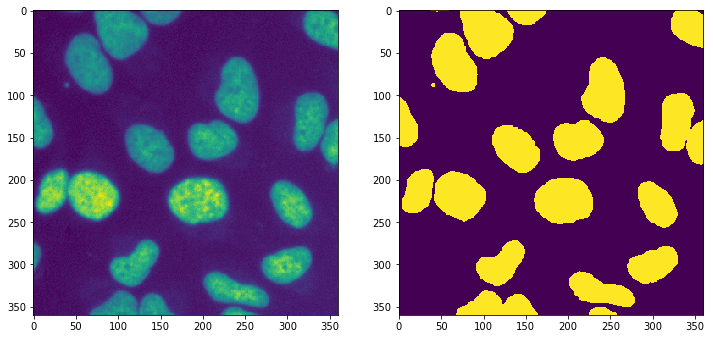

Resized Image and Resized Mask
Image #: 194. Image Sizes: (128, 128) (128, 128)


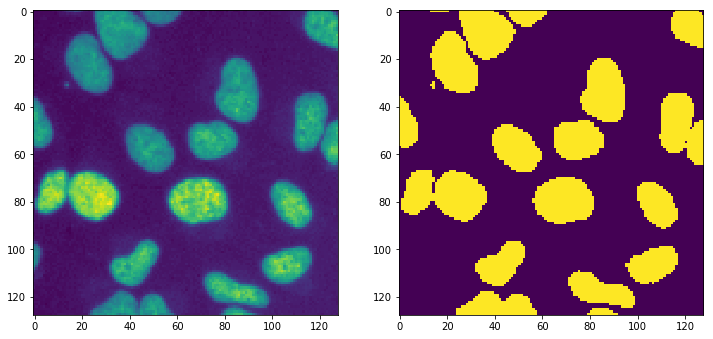

Prediction v. Mask
Image #: 194. Image Sizes: (128, 128) (128, 128)


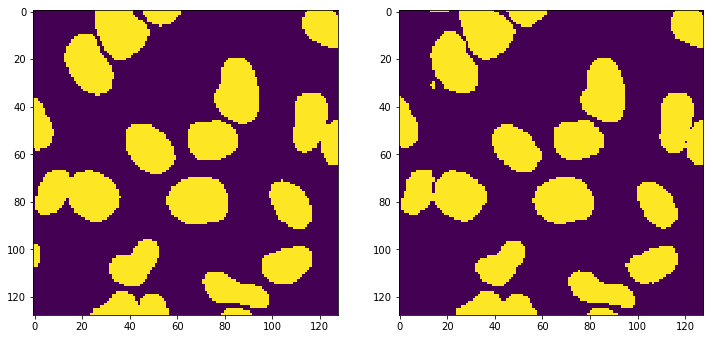

In [46]:
rand_img_num = randint(0,len(train_images))
#plot_check(compressed_train_images,compressed_train_masks,img_nums=[rand_img_num])
#plot_check(train_images,train_mask_images,img_nums=[rand_img_num])

print('Original Image and Mask')
plot_check(train_images,train_mask_images,img_nums=[194])
print('Resized Image and Resized Mask')
plot_check(resized_train_images,resized_train_masks,img_nums=[194])
print('Prediction v. Mask')
plot_check(np.squeeze(preds_train_t,axis=3),resized_train_masks,img_nums=[194])

# Results - Test Data

In [55]:
## Import Test Data 

#  --- make this a function ^^^
test_dirs = os.listdir(test_root)
test_filenames=[os.path.join(test_root,file_id) + "/images/"+file_id+".png" for file_id in test_dirs]
# Convert to B&W inline
#train_images=[cv2.cvtColor(cv2.imread(imagefile),cv2.COLOR_BGR2GRAY) for imagefile in train_filenames]
test_images=[imread(imagefile,as_grey=True) for imagefile in test_filenames]
resized_test_images = [ img_as_uint(resize(image,(img_width,img_height))) for image in test_images] 
test_X = np.reshape(np.array(resized_test_images),(len(resized_test_images),img_height,img_width,1))

final_model = load_model(model_checkpoint_file, custom_objects={'dice_coef': dice_coef, 'bce_dice_loss':bce_dice_loss})
preds_test = final_model.predict(test_X, verbose=1)

preds_test_t = (preds_test > 0.5) # to match our training dataset

# Use this instead if you want color images
#train_images=[imread(imagefile) for imagefile in train_filenames]


C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-p

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-p

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-p

C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\595559\AppData\Local\Continuum\anaconda3\lib\site-p

65/65 [==============================] - 47s 730ms/step


In [61]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test_t)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test_t[i]), 
                                       (test_images[i].shape[0], test_images[i].shape[1]), 
                                       mode='constant', preserve_range=True))

In [56]:
resized_test_images[0].dtype

dtype('uint16')

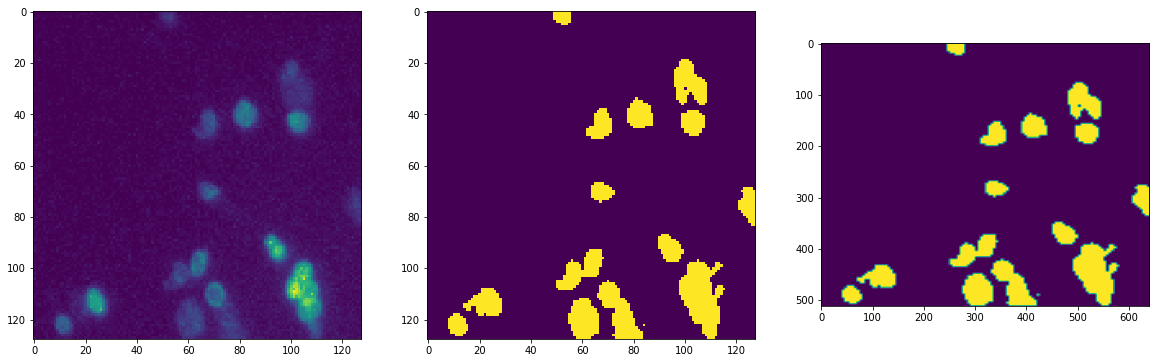

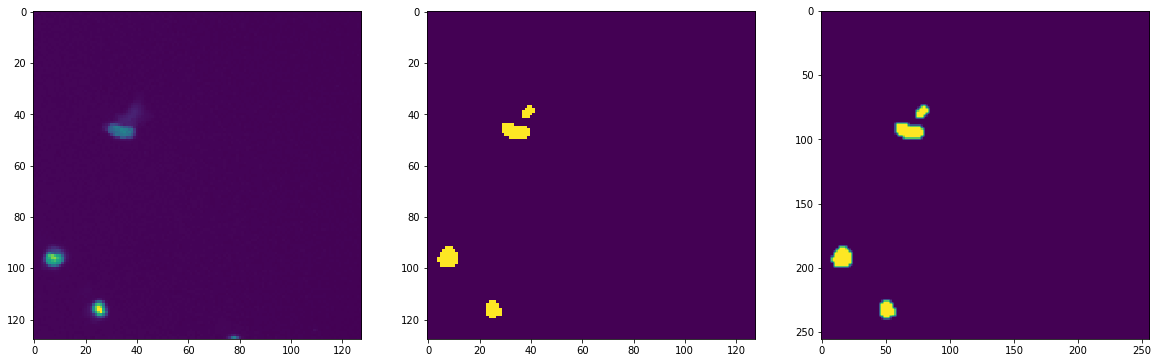

In [63]:
# Plot images side by side for a list of datasets
def plot_side_by_side(ds_list,image_num):
    #print('Image #: ' + str(image_num) + '. Image Sizes: ' + str(image_ds[image_num].shape) + ' ' + str(mask_ds[image_num].shape))
    fig = plt.figure(figsize=(20,10))

    for i in range(len(ds_list)):
        ax1 = fig.add_subplot(1,len(ds_list),i+1)
        ax1.imshow(ds_list[i][image_num])

    plt.show()
    
# Plots random corresponding images and masks
def plot_check(ds_list,rand_imgs=None,img_nums=None):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(ds_list, randint(0,len(ds_list[0])-1))
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(ds_list,img_nums[i])
    
#plot_side_by_side(train_images,train_mask_images,38)
# Plot a few random images 
#plot_check(train_images,train_masks,rand_imgs=3)
plot_check([np.squeeze(test_X,axis=3),np.squeeze(preds_test_t,axis=3),preds_test_upsampled],rand_imgs=2)
#plot_check([test_images,resized_test_images,np.squeeze(preds_test,axis=3)],rand_imgs=3)
#plot_check(train_images,cv2_masks,rand_imgs=3)

In [67]:
test_dirs[0]

'0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5'

In [64]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [70]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_dirs):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [72]:
import pandas as pd

In [73]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('bwmodel_v5_sub.csv', index=False)

In [ ]:
Ideas
 - Experiment with compression of training data. Am I preserving as much detail
    as I can in dtype np.uint8 (values of 0 to 255) ?
- Color vs B&W?
- Combine mask and prediction images to show false positives and negatives
- What is the best resizing method? Reflect??
- Put computer vision / threshold method output as an input to neural net
- Output intermediate layers for inspection
- Crop images to train networks faster for testing ??
- Take random crops of images to create, and then combine outputs in the end
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?
- Pseudo-labelled data